# Overview of the OMNI behavioral dataset

The OMNI behavioral  data are in a csv (comma delimited) file containing one row for every English-Lithuanian word pair shown to each participant. The file includes the timestamps of all event types — study trials, judgment of learning trials (JOLs), and recall trials — along with any behavioral output (e.g., JOLs, accuracy on the recall test).

## Descriptions of the data columns (using the header names included in the csv)

* `delay_group`: the approximate study to recall lag for this participant
    * Note that the exact time between study and test for a particular person should be obtained from the included timestamps.
    * A: immediate recall after end of study and JOL blocks
    * C: 24h study-recall lag
    * E: 48h study-recall lag (n = 1)
    * F: 72h study-recall lag
    * PRISMAF: 72h study-recall lag (study session in MRI)
    * H: 168h study-recall lag
   
   
* `participant_id`: unique identifier for each participant (delay-group + numeric)


* `lith_word_studied`: the lithuanian word in a studied pair


* `eng_word_studied`: the english word in a studied pair


* `studyN_start`: a numeric timestamp in seconds for the start time of study trial N
    * Note that all study events were four seconds duration. 


* `jol_start`: a numeric timestamp in seconds for the start time of the JOL trial


* `recall_trial`: a numeric timestamp in seconds for the start time of the recall trial


* `jol_value`: numeric responses from 0-100 indicating confidence that a given word will be remembered


* `eng_word_response`: the participant's english response for a given recall test trial


* `recall_accuracy`: the participant's recall accuracy


* `study_test_lag`: the time between the 5th study repetition and the recall trial for the given word


* `is_mri_trial_N`: a binary value that indicates whether there was MRI data collected for study repetition N for a particular participant and word
    * 1: there is MRI data for this study repetition for this person on this word
    * 0: there is no MRI data for this study repetition for this person on this word
    * These cells will always be zero for participants that are **not** in the `PRISMAF` delay_group
    * For the PRISMAF participants there is generally MRI data for each of the five study repetitions of each word, but due to occasional issues in data acquisition (e.g., scanner crash) or data quality (e.g., lots of motion during timepoints surrounding study trial) there might be isolated study trials with no data
    

* `IC_X_mri_emit_N`: these columns contain the MRI observations for each trial
    * The current data release includes estimates of single trial MRI activation levels from each of a set of independent components identified using the GIFT-ICA toolbox
    * Each component is identified as `IC_X`. `X` is a unique number assigned to each component and does not reflect a ranking of the components
    * Where MRI data exist, there is an MRI observation (emission) from each component for each study repetition of each word. For example, `IC_32_mri_emit_2` has the activation estimate for component 32 on study repetition 2
    * If there is no MRI observation for a particular combination of person, word, and study repetition these cells will be NaN
    * NOTE: there are components that were not included in these analyses and so there will sometimes be missing IC_X numbers (these mostly reflect components that loaded heavily on CSF or other nuisance sources and these components were discarded prior to estimating the memory model)
   
    






## Importing the data 

In [2]:
# Load necessary libraries
import csv
import pandas as pd
import numpy as np
import scipy.stats.stats
import matplotlib.pyplot as plt

In [3]:
# Set the location and name of the datafile to be loaded
data_dir = '/path/to/the/csv/file/'
data_file = 'omni_behav_and_MRI_IC_data_release_Aug-2018.csv'

# Use pandas to read the csv directly into a dataframe
df = pd.read_csv(data_dir + data_file)

# Look at the first few rows of the dataframe
df.head()

,lith_word_studied,eng_word_studied,participant_id,delay_group,study1_start,study2_start,study3_start,study4_start,study5_start,jol_start,...,IC_8_mri_emit_1,IC_8_mri_emit_2,IC_8_mri_emit_3,IC_8_mri_emit_4,IC_8_mri_emit_5,IC_9_mri_emit_1,IC_9_mri_emit_2,IC_9_mri_emit_3,IC_9_mri_emit_4,IC_9_mri_emit_5
0,akis,eye,A1,A,1461597710,1461598557,1461599141,1461599859,1461600407,1461600826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,arbata,tea,A1,A,1461597389,1461598204,1461598833,1461599532,1461600070,1461600740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,batas,shoe,A1,A,1461597682,1461598530,1461599154,1461599849,1461600397,1461600824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bugnas,drum,A1,A,1461597262,1461598085,1461598683,1461599393,1461599985,1461600719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,burna,mouth,A1,A,1461597421,1461598317,1461598891,1461599597,1461600185,1461600758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Looking at the data

Below are a few basic examples of how to look at and visualize the provided data.

In [11]:
# Look at percent of words correctly recalled by each participant
 
# Get the overall percent correct (number of words correctly recalled / number of recall trials)
# Make a new df that takes the mean of recall_accuracy and study_test_lag, grouping rows (word pairs) 
# by participant_id

df_mean = df[['participant_id', 'recall_accuracy', 'study_test_lag']].groupby(['participant_id']).mean()
df_mean.head()

,recall_accuracy,study_test_lag
participant_id,,
A1,0.644444,19.117407
A10,0.555556,18.594074
A11,0.444444,22.492963
A12,0.955556,13.335556
A13,0.400000,14.812963


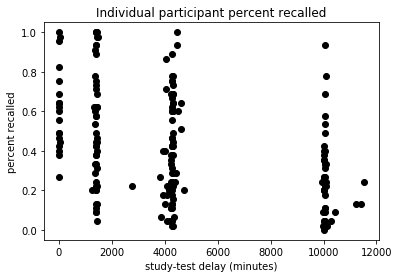

In [12]:
# Plot the percent correct for each participant according to study-test delay
plt.plot(df_mean['study_test_lag'].values, df_mean['recall_accuracy'].values, 'ko')
plt.xlabel('study-test delay (minutes)')
plt.ylabel('percent recalled')
plt.title('Individual participant percent recalled')
plt.show()

In [13]:
# Look at the relationship between JOL ratings given to each word and overall accuracy
# (collapsed across study delay groups)

# Get overall percent correct and average JOL rating for each word 
df_jol = df[['lith_word_studied','delay_group','recall_accuracy','jol_value']].groupby(['lith_word_studied']).mean()
df_jol.head()

,recall_accuracy,jol_value
lith_word_studied,,
akis,0.562500,72.583333
arbata,0.463542,71.630208
batas,0.432292,68.234375
bugnas,0.432292,65.447917
burna,0.473958,71.994792


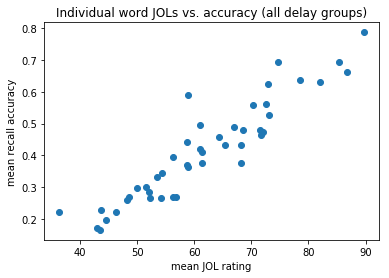

r = 0.93, (p = 0.0000)


In [14]:
# Plot mean JOLs against mean recall accuracy

plt.plot(df_jol['jol_value'],df_jol['recall_accuracy'],'o')
plt.xlabel('mean JOL rating')
plt.ylabel('mean recall accuracy')
plt.title('Individual word JOLs vs. accuracy (all delay groups)')
plt.show()

# Look at the correlation

r,p = scipy.stats.pearsonr(df_jol['jol_value'],df_jol['recall_accuracy'])
print("r = {:0.2f}, (p = {:0.4f})".format(r,p))

In [22]:
# Get fMRI activations for one participant

# The MRI participants all have delay_group = "PRISMAF"
# Make a data frame with only the fMRI participants:

df_mri =  df[df['delay_group']=="PRISMAF"]
df_mri.head()

# # Alternatively, look for string match in participant_id
# df_mri = df[df['participant_id'].str.contains("PRISMAF")]
# df_mri.head()

,lith_word_studied,eng_word_studied,participant_id,delay_group,study1_start,study2_start,study3_start,study4_start,study5_start,jol_start,...,IC_8_mri_emit_1,IC_8_mri_emit_2,IC_8_mri_emit_3,IC_8_mri_emit_4,IC_8_mri_emit_5,IC_9_mri_emit_1,IC_9_mri_emit_2,IC_9_mri_emit_3,IC_9_mri_emit_4,IC_9_mri_emit_5
7605,akis,eye,PRISMAF11,PRISMAF,1501437307,1501438044,1501438701,1501439496,1501440179,1501441933,...,-0.381443,-0.070368,0.598531,-0.823248,0.204800,-0.294047,0.332953,1.410906,1.006929,-0.414794
7606,arbata,tea,PRISMAF11,PRISMAF,1501436989,1501437694,1501438395,1501439172,1501439845,1501441830,...,-0.438763,1.817122,-0.200181,-0.622961,-0.409500,-0.353136,0.237676,-0.302713,0.326824,-0.434606
7607,batas,shoe,PRISMAF11,PRISMAF,1501437279,1501438018,1501438713,1501439486,1501440169,1501441928,...,0.345199,-0.152520,-1.564054,0.412271,-1.674230,1.016335,-1.385580,0.088164,-0.955398,-0.335795
7608,bugnas,drum,PRISMAF11,PRISMAF,1501436863,1501437576,1501438247,1501439034,1501439761,1501441809,...,0.195145,0.372711,0.640122,-0.116109,-0.042684,-0.832577,0.247965,-0.109925,-0.205294,-0.019220
7609,burna,mouth,PRISMAF11,PRISMAF,1501437021,1501437806,1501438453,1501439236,1501439959,1501441848,...,0.344884,-2.012012,-0.384314,0.321429,-1.657513,-0.844162,-0.190956,-0.650588,0.504105,0.362444


In [60]:
# Look at the data for one word in one participant
this_participant = 'PRISMAF11'
this_word = 'akis'

df_single_subject = df_mri[(df_mri['participant_id']==this_participant) & (df_mri['lith_word_studied']==this_word)]
df_single_subject

,lith_word_studied,eng_word_studied,participant_id,delay_group,study1_start,study2_start,study3_start,study4_start,study5_start,jol_start,...,IC_8_mri_emit_1,IC_8_mri_emit_2,IC_8_mri_emit_3,IC_8_mri_emit_4,IC_8_mri_emit_5,IC_9_mri_emit_1,IC_9_mri_emit_2,IC_9_mri_emit_3,IC_9_mri_emit_4,IC_9_mri_emit_5
7605,akis,eye,PRISMAF11,PRISMAF,1501437307,1501438044,1501438701,1501439496,1501440179,1501441933,...,-0.381443,-0.070368,0.598531,-0.823248,0.2048,-0.294047,0.332953,1.410906,1.006929,-0.414794


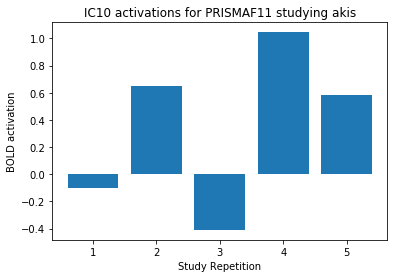

In [84]:
#### get MRI activation from one of the components for each study trial of 'this_word'
# a list of all the dataframe columns containing "emit"
all_components_names = [c for c in df_single_subject.columns.tolist() if c.find("emit")!=-1]

# which IC to use?
component_number = 10

# this is the prefix for each column of this component. 
# add a study repetition at the end to get a single column's value
component_prefix = 'IC_' + str(component_number) + '_mri_emit_'

trial_activations = np.empty((0,5))

# grab the current IC's emission for each study repetition
for study_rep in range(1,6):
    trial_activations = np.append(trial_activations, df_single_subject[component_prefix + str(study_rep)])


# plot the activations for each study repetition
fig, ax = plt.subplots()

x = np.arange(len(trial_activations))

ax.bar(x, trial_activations)

ax.set_xlabel('Study Repetition')
ax.set_xticks(x)
ax.set_xticklabels(('1', '2', '3', '4','5'))
ax.set_ylabel('BOLD activation')
ax.set_title('IC' + str(component_number) + ' activations for ' + this_participant + ' studying ' + this_word)
plt.show()